In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/train_public.csv')
test_public = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/test_public.csv')

In [3]:
def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


cat_cols = ['employer_type', 'industry']

for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])


col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

In [4]:
def train_model(data_, test_, y_, folds_):
	oof_preds = np.zeros(data_.shape[0])
	sub_preds = np.zeros(test_.shape[0])
	feature_importance_df = pd.DataFrame()
	feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
	for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
		trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
		val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
		clf = LGBMClassifier(
			n_estimators=4000,
			learning_rate=0.08,
			num_leaves=2**5,
			colsample_bytree=.65,
			subsample=.9,
			max_depth=5,
			reg_alpha=.3,
			reg_lambda=.3,
			min_split_gain=.01,
			min_child_weight=2,
			silent=-1,
			verbose=-1,
		)
		
		clf.fit(trn_x, trn_y, 
				eval_set= [(trn_x, trn_y), (val_x, val_y)], 
				eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
				)
		
		oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
		sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
		
		fold_importance_df = pd.DataFrame()
		fold_importance_df["feature"] = feats
		fold_importance_df["importance"] = clf.feature_importances_
		fold_importance_df["fold"] = n_fold + 1
		feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
		
		print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
		del clf, trn_x, trn_y, val_x, val_y
		gc.collect()
		
	print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
	
	test_['isDefault'] = sub_preds
	
	return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df

In [5]:
y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=0)
oof_preds, test_preds, importances = train_model(train_data, test_public, y, folds)

test_public['isDefault'] = test_preds['isDefault']

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.956777	training's binary_logloss: 0.220192	valid_1's auc: 0.870056	valid_1's binary_logloss: 0.309288
Early stopping, best iteration is:
[83]	training's auc: 0.948514	training's binary_logloss: 0.231058	valid_1's auc: 0.871377	valid_1's binary_logloss: 0.307244
Fold  1 AUC : 0.871377
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.936609	training's binary_logloss: 0.247564	valid_1's auc: 0.889619	valid_1's binary_logloss: 0.293446
Fold  2 AUC : 0.889619
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[56]	training's auc: 0.934488	training's binary_logloss: 0.249517	valid_1's auc: 0.883421	valid_1's binary_logloss: 0.300015
Fold  3 AUC : 0.883421
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.955204	training's binary_logloss: 0.222833	valid_1's auc:

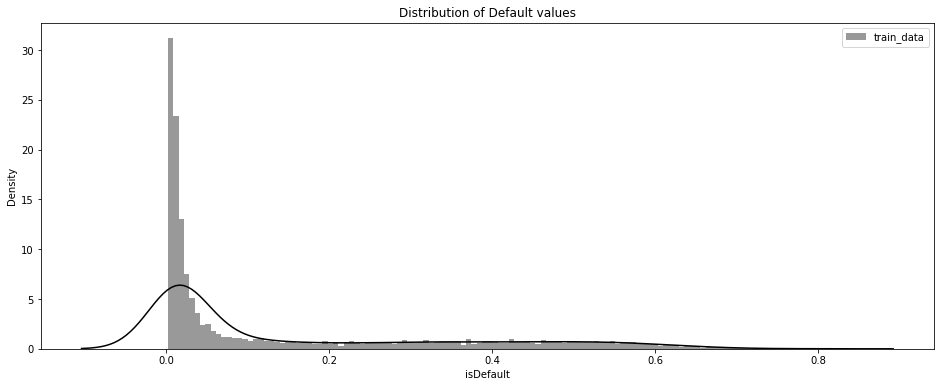

In [6]:
#看一下test_public的isDefault的概率分布

plt.figure(figsize=(16,6))
plt.title("Distribution of Default values")
sns.distplot(test_public['isDefault'],color="black", kde=True,bins=120, label='train_data')
plt.legend();plt.show()

In [7]:
print(test_public[test_public['isDefault']>0.50]['isDefault'].count())
print(test_public[test_public['isDefault']>0.20]['isDefault'].count())

454
1461


In [8]:
v_cut = 0.2
nw_test_data = test_public[test_public['isDefault']<v_cut]

#小于0.5赋值为0
nw_test_data.loc[nw_test_data['isDefault']<v_cut,'isDefault'] = 0

nw_train_data = pd.concat([train_data,nw_test_data]).reset_index(drop=True)

#再次训练新模型
y = nw_train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=0)
oof_preds, test_preds, importances = train_model(nw_train_data, test_public, y, folds)

test_public['isDefault'] = test_preds['isDefault']

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.949488	training's binary_logloss: 0.192242	valid_1's auc: 0.915391	valid_1's binary_logloss: 0.217312
Fold  1 AUC : 0.915391
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.967403	training's binary_logloss: 0.166898	valid_1's auc: 0.912852	valid_1's binary_logloss: 0.232819
Early stopping, best iteration is:
[62]	training's auc: 0.952614	training's binary_logloss: 0.186052	valid_1's auc: 0.915181	valid_1's binary_logloss: 0.231023
Fold  2 AUC : 0.915181
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[38]	training's auc: 0.942373	training's binary_logloss: 0.202439	valid_1's auc: 0.903996	valid_1's binary_logloss: 0.234125
Fold  3 AUC : 0.903996
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[53]	training's auc: 0.94881	training's binary

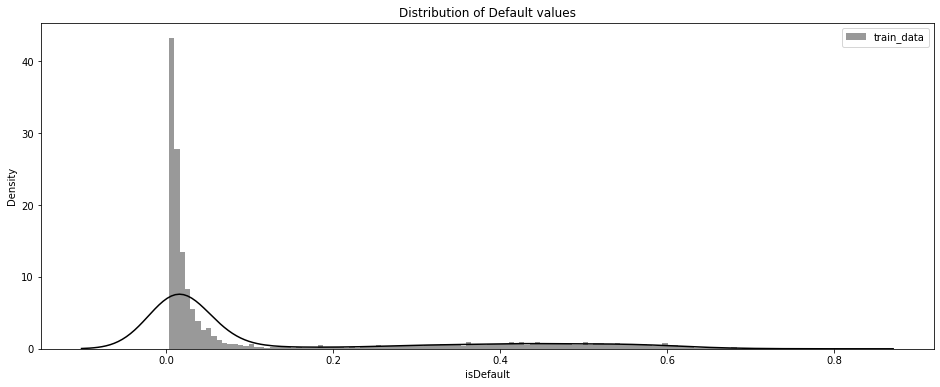

In [9]:
#看一下test_public的isDefault的概率分布

plt.figure(figsize=(16,6))
plt.title("Distribution of Default values")
sns.distplot(test_public['isDefault'],color="black", kde=True,bins=120, label='train_data')
plt.legend();plt.show()

In [10]:
print(test_public[test_public['isDefault']>0.50]['isDefault'].count())
print(test_public[test_public['isDefault']>0.2]['isDefault'].count())

427
1250


In [11]:
train_data = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/train_public.csv')
test_data = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/test_public.csv')
test_preds=test_preds.rename(columns={'id': 'loan_id'})
test_preds.loc[test_preds['isDefault']<0.2,'isDefault'] = 0
nw_sub=test_preds[(test_preds['isDefault']==0)]
nw_test_data=test_data.merge(nw_sub,on='loan_id',how='inner')
nw_train_data = pd.concat([train_data,nw_test_data]).reset_index(drop=True)
nw_train_data.to_csv("G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/submit_12/nw_train_public.csv",index=0)